In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer


In [2]:
path ="airbnb_listings.csv"

df = pd.read_csv(path)
df.head(1)

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,33159143,https://www.airbnb.com/rooms/33159143,"PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH",80% of the house + yourCozy room ... in Scripp...,"Full bed, private bath...",80% of the house + yourCozy room ... in Scripp...,The neighborhood is a typical Southern Califor...,Have alarm system if you choose to use... I wi...,You can park in the drive way or plenty of spa...,"Kitchen, Dining room, Living room, Very Comfor...",...,NaN,NaN,NaN,NaN,f,t,f,strict_14_with_grace_period,f,f


In [3]:
df.columns

Index(['id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'thumbnail_url', 'host_id', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13051 entries, 0 to 13050
Data columns (total 75 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13051 non-null  int64  
 1   listing_url                       13051 non-null  object 
 2   name                              13051 non-null  object 
 3   summary                           12635 non-null  object 
 4   space                             10080 non-null  object 
 5   description                       12836 non-null  object 
 6   neighborhood_overview             9138 non-null   object 
 7   notes                             7103 non-null   object 
 8   transit                           8261 non-null   object 
 9   access                            8224 non-null   object 
 10  interaction                       8665 non-null   object 
 11  house_rules                       9587 non-null   object 
 12  thum

In [5]:


# ------------------------
# Helper cleaning functions
# ------------------------
def clean_currency(series):
    """Convert '$1,234.00' -> 1234.0, treat missing/empty as 0."""
    return (
        series.fillna("0")
              .astype(str)
              .str.replace(r"[\$,]", "", regex=True)
              .replace("", "0")
              .astype(float)
    )

def clean_bool(series):
    """Convert 't'/'f', 'True'/'False', True/False -> 1/0."""
    s = series.astype(str).str.lower()
    return s.isin(["t", "true", "1"]).astype(int)

def clean_percent(series):
    """Convert '95%' -> 0.95, handle NaN."""
    s = series.astype(str).str.strip()
    s = s.str.replace("%", "", regex=False)
    s = pd.to_numeric(s, errors="coerce") / 100.0
    return s.fillna(s.mean())

# ------------------------
# Clean target (price + log_price)
# ------------------------
df["price"] = clean_currency(df["nightly_price"])
df["log_price"] = np.log1p(df["price"])

# ------------------------
# Select features we keep
# ------------------------
feature_cols = [
    "neighbourhood_cleansed", "latitude", "longitude",
    "property_type", "room_type", "accommodates", "bathrooms",
    "bedrooms", "beds", "bed_type", "amenities",
    "host_since", "host_response_time", "host_response_rate",
    "host_is_superhost", "host_listings_count",
    "host_total_listings_count", "host_has_profile_pic",
    "host_identity_verified", "security_deposit",
    "cleaning_fee", "guests_included", "extra_people",
    "minimum_nights", "maximum_nights", "number_of_reviews",
    "number_of_stays", "review_scores_rating",
    "requires_license", "instant_bookable",
    "is_business_travel_ready", "cancellation_policy",
    "require_guest_profile_picture",
    "require_guest_phone_verification",
]

data = df[feature_cols].copy()

# ------------------------
# Feature engineering
# ------------------------

# Currency features
for col in ["security_deposit", "cleaning_fee", "extra_people"]:
    data[col] = clean_currency(data[col])

# Boolean-like features
bool_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified",
    "requires_license", "instant_bookable", "is_business_travel_ready",
    "require_guest_profile_picture", "require_guest_phone_verification",
]
for col in bool_cols:
    data[col] = clean_bool(data[col])

# Response rate
data["host_response_rate"] = clean_percent(data["host_response_rate"])

# Host tenure in years
ref_date = pd.to_datetime("2020-01-01")  # or use max(df["host_since"]) or similar
host_since_parsed = pd.to_datetime(df["host_since"], errors="coerce")
data["host_tenure_years"] = (ref_date - host_since_parsed).dt.days / 365.0
data["host_tenure_years"] = data["host_tenure_years"].fillna(
    data["host_tenure_years"].median()
)

# Review_scores_rating: simple imputation
data["review_scores_rating"] = pd.to_numeric(
    data["review_scores_rating"], errors="coerce"
)
data["review_scores_rating"] = data["review_scores_rating"].fillna(
    data["review_scores_rating"].mean()
)

# Number of amenities
def count_amenities(s):
    # s looks like: "{TV,Wifi,Kitchen,...}"
    s = str(s).strip()
    if s == "" or s == "nan":
        return 0
    # strip {} then split on comma
    s = s.strip("{}")
    if s == "":
        return 0
    return len([x for x in s.split(",") if x.strip() != ""])

data["num_amenities"] = data["amenities"].apply(count_amenities)

# We will drop raw 'amenities' string and 'host_since' in the model,
# keeping their engineered versions instead.
data = data.drop(columns=["amenities", "host_since"])

# ------------------------
# Train/validation split
# ------------------------
X = data
y = df["log_price"]  # our modeling target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


C:\Users\arvos\AppData\Local\Temp\ipykernel_31284\555208253.py:76: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  host_since_parsed = pd.to_datetime(df["host_since"], errors="coerce")


Train shape: (10440, 34)
Val shape: (2611, 34)


In [6]:
# Helper function for evaluation

def evaluate_on_price(y_true_log, y_pred_log, label="model"):
    """Compute MAE/RMSE in original dollar space, plus log-space RMSE."""
    # back-transform
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))

    print(f"=== {label} ===")
    print(f"MAE (dollars): {mae:,.2f}")
    print(f"RMSE (dollars): {rmse:,.2f}")
    print(f"RMSE (log_price): {rmse_log:.4f}")
    print()
    return {"mae": mae, "rmse": rmse, "rmse_log": rmse_log}


# Baseline 0: Predict using global mean of log price

In [7]:
# Baseline 0: always predict global mean log_price (from training set)
global_mean_log_price = y_train.mean()

y_pred_train_b0 = np.full_like(y_train, fill_value=global_mean_log_price)
y_pred_val_b0 = np.full_like(y_val, fill_value=global_mean_log_price)

metrics_b0_train = evaluate_on_price(y_train, y_pred_train_b0, label="Baseline 0 (train)")
metrics_b0_val   = evaluate_on_price(y_val, y_pred_val_b0, label="Baseline 0 (val)")


=== Baseline 0 (train) ===
MAE (dollars): 140.25
RMSE (dollars): 344.54
RMSE (log_price): 0.8267

=== Baseline 0 (val) ===
MAE (dollars): 143.23
RMSE (dollars): 387.04
RMSE (log_price): 0.8231



# Baseline 1: Predict using mean by neighborhood/room type

In [8]:
# Use neighbourhood_cleansed + room_type as a grouped baseline
group_cols = ["neighbourhood_cleansed", "room_type"]

# Use original X_train, not the encoded version
train_group = df.loc[X_train.index, group_cols].copy()
val_group   = df.loc[X_val.index,   group_cols].copy()

train_group["log_price"] = y_train.values

# Compute group means on training data
group_means = (
    train_group
    .groupby(group_cols)["log_price"]
    .mean()
    .reset_index()
)

# Merge group mean back to train/val using left joins
train_merge = train_group.merge(
    group_means, on=group_cols, how="left", suffixes=("", "_group_mean")
)
val_merge = val_group.merge(
    group_means, on=group_cols, how="left"
)

# If a group wasn't seen in training, fall back to global mean
train_pred_log = train_merge["log_price_group_mean"].fillna(global_mean_log_price)
val_pred_log   = val_merge["log_price"].fillna(global_mean_log_price)

metrics_b1_train = evaluate_on_price(y_train, train_pred_log, label="Baseline 1 (train)")
metrics_b1_val   = evaluate_on_price(y_val,   val_pred_log,   label="Baseline 1 (val)")


=== Baseline 1 (train) ===
MAE (dollars): 115.80
RMSE (dollars): 319.92
RMSE (log_price): 0.6182

=== Baseline 1 (val) ===
MAE (dollars): 121.38
RMSE (dollars): 368.98
RMSE (log_price): 0.6383



## One hot encode categoricals and scale numerics (ML Prep)

In [9]:
# ------------------------
# 7. ColumnTransformer for ML models (with imputation)
# ------------------------

numeric_features = [
    "latitude", "longitude",
    "accommodates", "bathrooms", "bedrooms", "beds",
    "host_response_rate", "host_listings_count", "host_total_listings_count",
    "security_deposit", "cleaning_fee", "guests_included", "extra_people",
    "minimum_nights", "maximum_nights", "number_of_reviews",
    "number_of_stays", "review_scores_rating",
    "host_tenure_years", "num_amenities",
] + bool_cols  # your bool_cols list from earlier

categorical_features = [
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "bed_type",
    "host_response_time",
    "cancellation_policy",
]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)


# Model 1: Ridge Regression (Linear)

In [10]:
X_train.isna().sum().sort_values(ascending=False).head(20)


host_response_time                  1724
beds                                   6
host_total_listings_count              5
host_listings_count                    5
bathrooms                              2
bedrooms                               2
requires_license                       0
maximum_nights                         0
number_of_reviews                      0
number_of_stays                        0
review_scores_rating                   0
neighbourhood_cleansed                 0
instant_bookable                       0
extra_people                           0
is_business_travel_ready               0
cancellation_policy                    0
require_guest_profile_picture          0
require_guest_phone_verification       0
host_tenure_years                      0
minimum_nights                         0
dtype: int64

In [11]:
ridge_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", Ridge(alpha=1.0, random_state=42))
    ]
)

ridge_model.fit(X_train, y_train)
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_val_ridge   = ridge_model.predict(X_val)

metrics_ridge_train = evaluate_on_price(y_train, y_pred_train_ridge, label="Ridge (train)")
metrics_ridge_val   = evaluate_on_price(y_val,   y_pred_val_ridge,   label="Ridge (val)")


=== Ridge (train) ===
MAE (dollars): 84.16
RMSE (dollars): 287.83
RMSE (log_price): 0.4664

=== Ridge (val) ===
MAE (dollars): 89.09
RMSE (dollars): 345.69
RMSE (log_price): 0.4806



# Model 2: Random Forest

In [12]:
# Orignal Random forest model showed clear signs of overfitting. To combat this,
# a max depth of 15 (preiviously none) was implemented and the min samples per leaf was 
# increased to 10

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            max_depth=15,          # limit depth
            min_samples_leaf=10,   # require more samples in leaves
            random_state=42,
            n_jobs=-1,
        )),
    ]
)


rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_val_rf   = rf_model.predict(X_val)

metrics_rf_train = evaluate_on_price(y_train, y_pred_train_rf, label="Random Forest (train)")
metrics_rf_val   = evaluate_on_price(y_val,   y_pred_val_rf,   label="Random Forest (val)")


=== Random Forest (train) ===
MAE (dollars): 62.42
RMSE (dollars): 252.51
RMSE (log_price): 0.3490

=== Random Forest (val) ===
MAE (dollars): 80.33
RMSE (dollars): 331.58
RMSE (log_price): 0.4399



In [13]:
def get_feature_importances_from_pipeline(pipeline, feature_names):
    """
    Extract feature importances from a pipeline that contains:
      ("preprocess", preprocessor)
      ("model", RandomForestRegressor)    
    """
    # Step 1: Get the preprocessor and model
    preprocessor = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]
    
    # Step 2: Get transformed feature names
    # This will only work if you set:
    #   set_config(transform_output="pandas") earlier.
    # or you can use get_feature_names_out below.
    try:
        transformed_features = preprocessor.get_feature_names_out(feature_names)
    except AttributeError:
        # If using older sklearn:
        transformed_features = []
        for name, transformer, cols in preprocessor.transformers_:
            if name == "num":
                transformed_features.extend(cols)
            elif name == "cat":
                # Handle one-hot expanded features
                oh = transformer.named_steps.get("onehot", None)
                if oh:
                    cat_names = oh.get_feature_names_out(cols)
                    transformed_features.extend(cat_names)
    
    # Step 3: Extract importances
    importances = model.feature_importances_
    
    fi = pd.DataFrame({
        "feature": transformed_features,
        "importance": importances
    }).sort_values("importance", ascending=False)
    
    return fi

# Use the gini index to see which features contributed the most to the models performance
feature_importance_df = get_feature_importances_from_pipeline(rf_model, X_train.columns)
feature_importance_df.head(20)  # top 20 features


,feature,importance
4,num__bedrooms,0.369880
2,num__accommodates,0.139779
167,cat__room_type_Entire home/apt,0.099056
3,num__bathrooms,0.084187
1,num__longitude,0.068779
10,num__cleaning_fee,0.063159
0,num__latitude,0.025361
15,num__number_of_reviews,0.019726
16,num__number_of_stays,0.019545
13,num__minimum_nights,0.016020


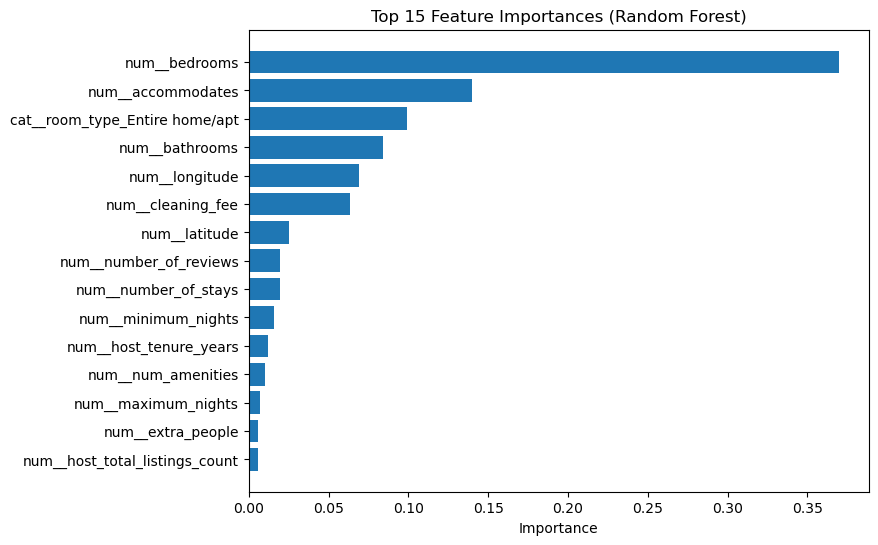

In [14]:
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df["feature"].head(top_n)[::-1],
         feature_importance_df["importance"].head(top_n)[::-1])
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Model 2: Hyperparameters tuned (randomized search)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf_base = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
        )),
    ]
)

param_dist = {
    "model__max_depth": [10, 15, 20, None],
    "model__min_samples_leaf": [1, 5, 10, 20],
    "model__max_features": ["sqrt", "log2", 0.5],
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="neg_mean_absolute_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_

y_pred_train_rf_best = best_rf_model.predict(X_train)
y_pred_val_rf_best   = best_rf_model.predict(X_val)

metrics_rf_best_train = evaluate_on_price(y_train, y_pred_train_rf_best, label="RF tuned (train)")
metrics_rf_best_val   = evaluate_on_price(y_val,   y_pred_val_rf_best,   label="RF tuned (val)")

print("Best params:", rf_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Use the gini index to see which features contributed the most to the models performance

tuned_feature_importance_df = get_feature_importances_from_pipeline(best_rf_model, X_train.columns)
tuned_feature_importance_df.head(20)

In [ ]:
top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(tuned_feature_importance_df["feature"].head(top_n)[::-1],
         tuned_feature_importance_df["importance"].head(top_n)[::-1])
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()